## Judge LLM.

Execute CoT_modelname_ollama.ipynb file before running this file.

In [1]:
import json
import re
import time
from statistics import mean, stdev
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!pip install langchain langchain-community


In [3]:
!pip install langchain tqdm nest_asyncio matplotlib pandas

In [4]:
from langchain_community.chat_models import ChatOllama
from langchain.schema import SystemMessage, HumanMessage




Evaluating:   0%|                                        | 0/10 [00:00<?, ?it/s]/var/folders/h0/mjy5y31j3w9ckq_2j_knm_800000gn/T/ipykernel_41654/1475030099.py:116: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="llama3.1:8b", temperature=temperature)
Evaluating: 100%|███████████████████████████████| 10/10 [01:17<00:00,  7.70s/it]

Partial save at entry 10
CSV exported to: Llama3_CS1QA_llm_as_judge.csv


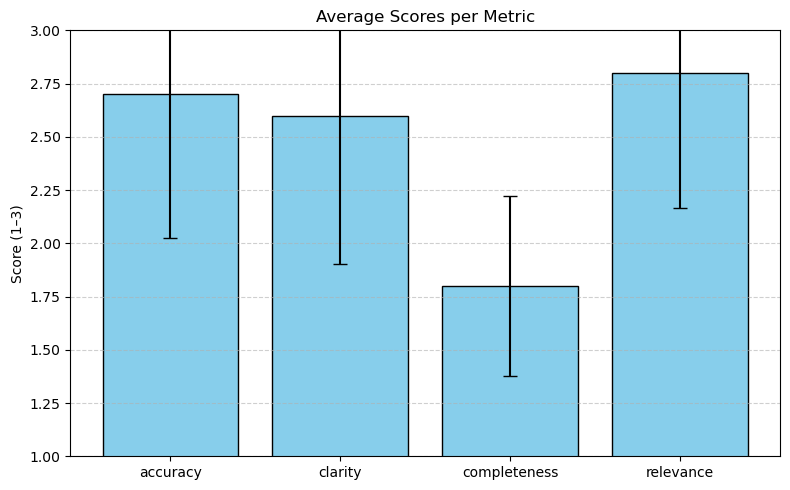

In [5]:
# ========== Setup ==========
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.asyncio import tqdm_asyncio
from langchain_community.chat_models import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
import asyncio

# ========== Prompt Builder ==========
def make_llm_eval_prompt(code, question, reference, prediction):
    return f"""
Code:
{code}

Question:
{question}

Reference Answer:
{reference}

Model Answer:
{prediction}
"""

# ========== System Prompt ==========
system_prompt = """
You are a large language model acting as a judge for assessing the performance of a Teaching Assistant (TA) in an introductory Python programming course.

The TA is an LLM that answers student questions about Python code. Your job is to evaluate the quality of the TA's answer.

You will receive:
- A Python code snippet
- A student question about that code
- A reference (correct) answer
- A TA LLM-generated answer (called the prediction)

Your task is to evaluate how well the TA's prediction answers the student's question, using the following four dimensions. For each, provide:
- An integer score from 1 to 3

### Accuracy
Score meanings:
- 1: Completely incorrect or irrelevant
- 2: Partially correct
- 3: Fully correct

### Completeness
Score meanings:
- 1: Omits key info
- 2: Partial
- 3: Fully covers all essential info

### Relevance
Score meanings:
- 1: Irrelevant
- 2: Partially related
- 3: Fully focused

### Clarity
Score meanings:
- 1: Confusing
- 2: Understandable but unclear
- 3: Clear and easy to follow

Example:

Code:
```python
from cs1media import *

# This code converts an image into a black & white poster.
threshold = 100
white = (255, 255, 255)
black = (0, 0, 0)

image = load_picture('./images/minion.jpg')
width, height = image.size()

for y in range(height):
    for x in range(width):
        r, g, b = image.get(x, y)
        average_brightness = (r + g + b) // 3
        if average_brightness > threshold:
            image.set(x, y, white)
        else:
            image.set(x, y, black)

image.show()

Question: And the standard for bright and dark - Is it my choice?
Reference Answer: Yes, you can divide the color into 3 equal parts
Prediction: Yes, you are correct that the choice of threshold values for determining whether a pixel is "bright" or "dark" is up to your discretion. The code provided in the question uses a hardcoded threshold value of 100, which may not be optimal for all images. You can experiment with different threshold values to see what works best for your specific use case.

Evaluation Output:
{
"accuracy": { "score": 2 },
"completeness": { "score": 1 },
"relevance": { "score": 3 },
"clarity": { "score": 3 }
}

Final Instructions:
Base your evaluation strictly on the content provided. Do not hallucinate missing information. Be consistent and objective.
Do not include reasoning or explanations.
Respond only with a JSON object in the exact format:
{
"accuracy": { "score": 1-3},
"completeness": {"score": 1-3},
"relevance": {"score": 1-3},
"clarity": {"score": 1-3}
}
"""

# ========== Async LangChain call ==========
async def call_llm_async(prompt, temperature=0.0):
    llm = ChatOllama(model="llama3.1:8b", temperature=temperature)
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=prompt)
    ]
    response = await llm.ainvoke(messages)
    return response.content

# ========== Extract JSON Scores ==========
def extract_all_scores(response_text):
    try:
        parsed = json.loads(response_text)
    except json.JSONDecodeError:
        return {}

    results = {}
    for metric, details in parsed.items():
        if isinstance(details, dict):
            score = details.get("score")
            if isinstance(score, int):
                results[metric] = {"score": score}
    return results

# ========== Save JSON ==========
def save_json_data(path, data):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

# ========== CSV Export ==========
def export_csv(flat_records, path="judge_scores.csv"):
    df = pd.DataFrame(flat_records)
    df.to_csv(path, index=False)
    print(f"CSV exported to: {path}")

# ========== Visualization ==========
def visualize_scores(flat_records):
    df = pd.DataFrame(flat_records)
    grouped = df.groupby("metric")["score"]
    avg_scores = grouped.mean()
    std_scores = grouped.std().fillna(0)

    plt.figure(figsize=(8, 5))
    plt.bar(
        avg_scores.index,
        avg_scores.values,
        yerr=std_scores.values,
        capsize=5,
        color='skyblue',
        edgecolor='black'
    )
    plt.title("Average Scores per Metric")
    plt.ylabel("Score (1–3)")
    plt.ylim(1, 3)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# ========== Async Evaluation ==========
async def evaluate_batch_async(data, output_path, save_every=1000):
    results = []
    flat_records = []

    try:
        with open(output_path, 'r', encoding='utf-8') as f:
            results = json.load(f)
    except FileNotFoundError:
        pass

    start_index = len(results)

    for i in tqdm_asyncio(range(start_index, len(data)), desc="Evaluating"):
        item = data[i]
        code = item["code"]
        question = item["question"]
        reference = item["answer"]
        prediction = item["prediction"]
        q_id = item.get("id", f"q{i+1}")

        prompt = make_llm_eval_prompt(code, question, reference, prediction)
        try:
            response = await call_llm_async(prompt)
        except Exception as e:
            print(f"Error at entry {i+1}: {e}")
            response = "{}"

        metric_results = extract_all_scores(response)
        sample_result = {
            "id": q_id,
            "code": code,
            "question": question,
            "reference":reference,
            "prediction": prediction
        }

        for metric in ["accuracy", "completeness", "relevance", "clarity"]:
            if metric in metric_results:
                score = metric_results[metric]["score"]
                sample_result[metric] = {"score": score}
                flat_records.append({
                    "id": q_id,
                    "code": code,
                    "question": question,
                    "prediction": prediction,
                    "metric": metric,
                    "score": score
                })
            else:
                sample_result[metric] = {"score": None}

        results.append(sample_result)

        if (i + 1) % save_every == 0 or (i + 1) == len(data):
            try:
                save_json_data(output_path, results)
                print(f"Partial save at entry {i+1}")
            except Exception as e:
                print(f"Warning: Failed to save at entry {i+1}: {str(e)}")

    return results, flat_records

# ========== Main Runner ==========
async def run_judge_eval():
    input_path = "Llama3_CS1QA_predictions.json"
    output_path = "Llama3_CS1QA_llm_as_judge.json"
    csv_path = "Llama3_CS1QA_llm_as_judge.csv"

    with open(input_path, 'r', encoding='utf-8') as f:
        dataset_all = json.load(f)

    # Optional chunking:
    # chunk_size = 5
    # dataset = dataset_all[3*chunk_size:5*chunk_size]
    dataset = dataset_all

    evaluated, flat_records = await evaluate_batch_async(dataset, output_path=output_path)
    save_json_data(output_path, evaluated)
    export_csv(flat_records, path=csv_path)
    visualize_scores(flat_records)

# ========== Launch in Jupyter Cell ==========
await run_judge_eval()
